# 📊 Portfolio Analytics Project

This notebook performs portfolio performance analysis, strategy backtesting, and visualizes risk metrics using historical price data of the top 20 S&P 500 companies (by market cap).

In [44]:
# STEP 1: Imports and Setup
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, expected_returns, risk_models
import warnings
warnings.filterwarnings("ignore")

In [46]:
# STEP 2: Define tickers (replace BRK-B with PEP for stability)
tickers = ["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "META", "AVGO", "TSLA", "WMT",
           "LLY", "JPM", "V", "UNH", "MA", "XOM", "JNJ", "PG", "HD", "CVX", "PEP"]

In [48]:
# STEP 3: Download adjusted closing prices
price_data = yf.download(tickers, start="2010-01-01", end="2025-01-01", auto_adjust=True)["Close"]
price_data = price_data.dropna(axis=1, how='all')  # Drop tickers with missing data
print(f"✅ Loaded price data for {len(price_data.columns)} tickers.")

[*********************100%***********************]  20 of 20 completed


✅ Loaded price data for 20 tickers.


In [50]:
# STEP 4: Calculate daily returns
daily_returns = price_data.pct_change().dropna()

In [52]:
# STEP 5: Equal Weight Strategy
equal_weights = np.array([1 / len(price_data.columns)] * len(price_data.columns))
equal_weight_returns = daily_returns.dot(equal_weights)
equal_cum_returns = (1 + equal_weight_returns).cumprod()

In [54]:
# STEP 6: Mean-Variance Optimization
mu = expected_returns.mean_historical_return(price_data)
S = risk_models.sample_cov(price_data)
ef = EfficientFrontier(mu, S)
opt_weights = ef.max_sharpe()
opt_weights_clean = ef.clean_weights()
print("🔧 Optimized Weights (Mean-Variance):")
print(opt_weights_clean)

🔧 Optimized Weights (Mean-Variance):
OrderedDict({'AAPL': 0.07079, 'AMZN': 0.0, 'AVGO': 0.15946, 'CVX': 0.0, 'GOOGL': 0.0, 'HD': 0.05574, 'JNJ': 0.0, 'JPM': 0.0, 'LLY': 0.32276, 'MA': 0.0, 'META': 0.0, 'MSFT': 0.0, 'NVDA': 0.0883, 'PEP': 0.0, 'PG': 0.0, 'TSLA': 0.07103, 'UNH': 0.10241, 'V': 0.0, 'WMT': 0.1295, 'XOM': 0.0})


In [56]:
# STEP 7: Portfolio Performance Metrics
mean_return = equal_weight_returns.mean()
volatility = equal_weight_returns.std()
sharpe_ratio = (mean_return / volatility) * np.sqrt(252)
print(f"📈 Annual Return: {mean_return * 252:.2%}")
print(f"📉 Annual Volatility: {volatility * np.sqrt(252):.2%}")
print(f"⚖️ Sharpe Ratio: {sharpe_ratio:.2f}")

📈 Annual Return: 25.44%
📉 Annual Volatility: 17.81%
⚖️ Sharpe Ratio: 1.43


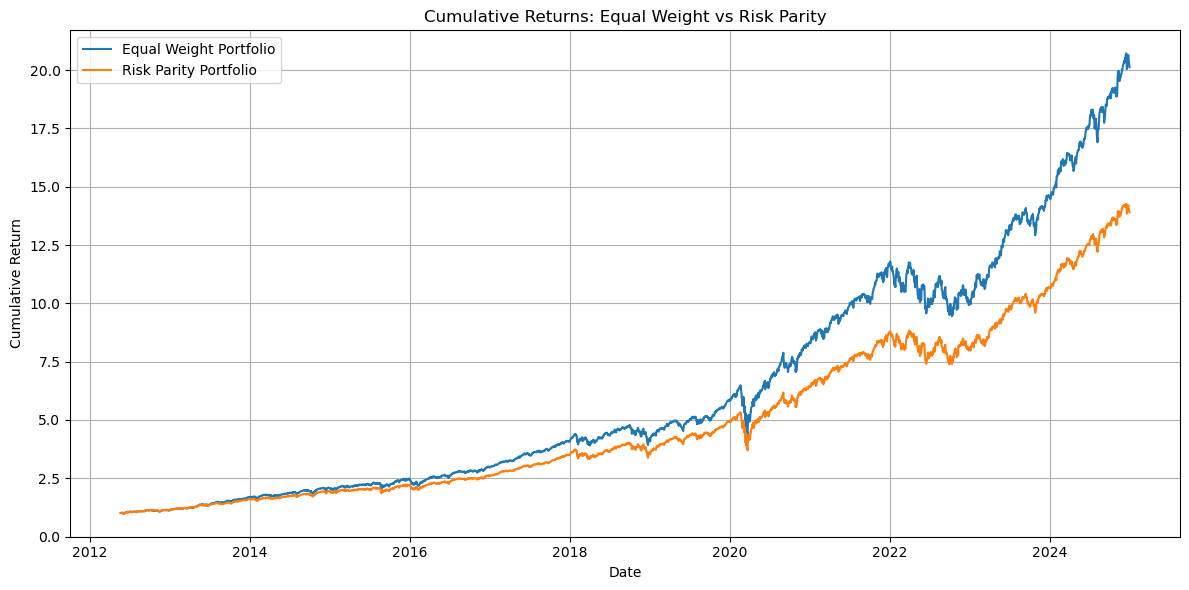

In [58]:
# STEP 8: Risk Parity Strategy (inverse volatility weighting)
inv_vol = 1 / daily_returns.std()
risk_parity_weights = inv_vol / inv_vol.sum()

# Portfolio return based on risk parity weights
risk_parity_returns = daily_returns.dot(risk_parity_weights)
risk_parity_cum_returns = (1 + risk_parity_returns).cumprod()

# Plot Risk Parity vs Equal Weight
plt.figure(figsize=(12,6))
plt.plot(equal_cum_returns, label="Equal Weight Portfolio")
plt.plot(risk_parity_cum_returns, label="Risk Parity Portfolio")
plt.title("Cumulative Returns: Equal Weight vs Risk Parity")
plt.xlabel("Date"); plt.ylabel("Cumulative Return"); plt.legend(); plt.grid(); plt.tight_layout()
plt.show()

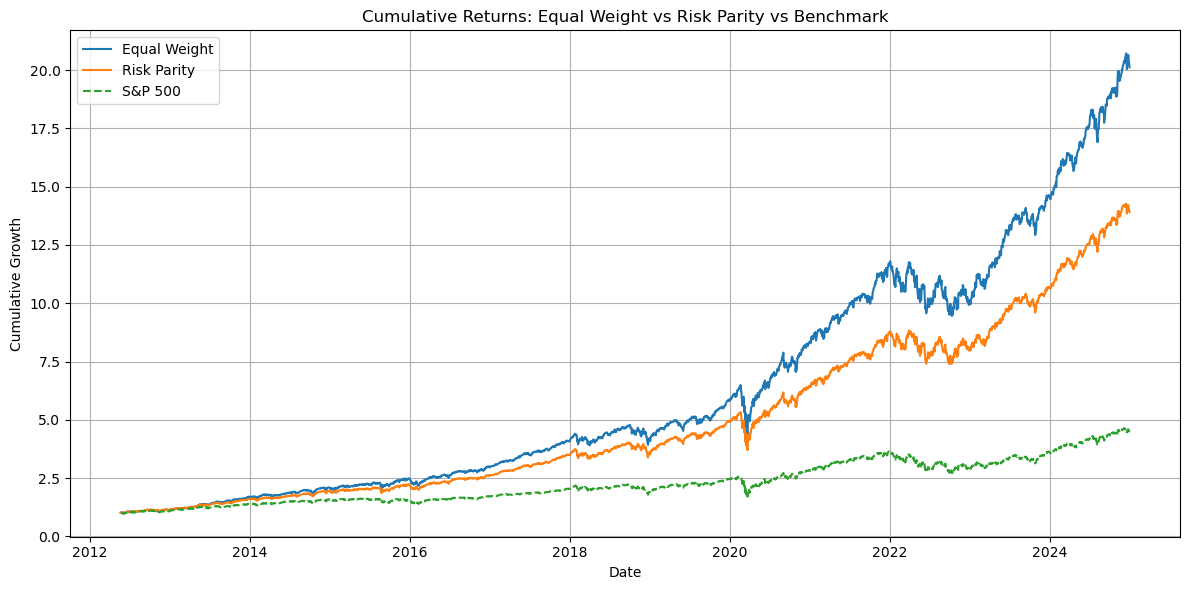

In [60]:
# STEP 8: Risk Parity Strategy
# Inverse volatility weighting
inv_vol = 1 / daily_returns.std()
risk_parity_weights = inv_vol / inv_vol.sum()

# Apply weights to get portfolio returns
risk_parity_returns = daily_returns.dot(risk_parity_weights)
risk_parity_cum_returns = (1 + risk_parity_returns).cumprod()

# Compare strategies visually
plt.figure(figsize=(12,6))
plt.plot(equal_cum_returns, label="Equal Weight")
plt.plot(risk_parity_cum_returns, label="Risk Parity")
plt.plot(benchmark_cum, label="S&P 500", linestyle='--')
plt.title("Cumulative Returns: Equal Weight vs Risk Parity vs Benchmark")
plt.xlabel("Date"); plt.ylabel("Cumulative Growth"); plt.grid(); plt.legend(); plt.tight_layout()
plt.show()

[*********************100%***********************]  1 of 1 completed


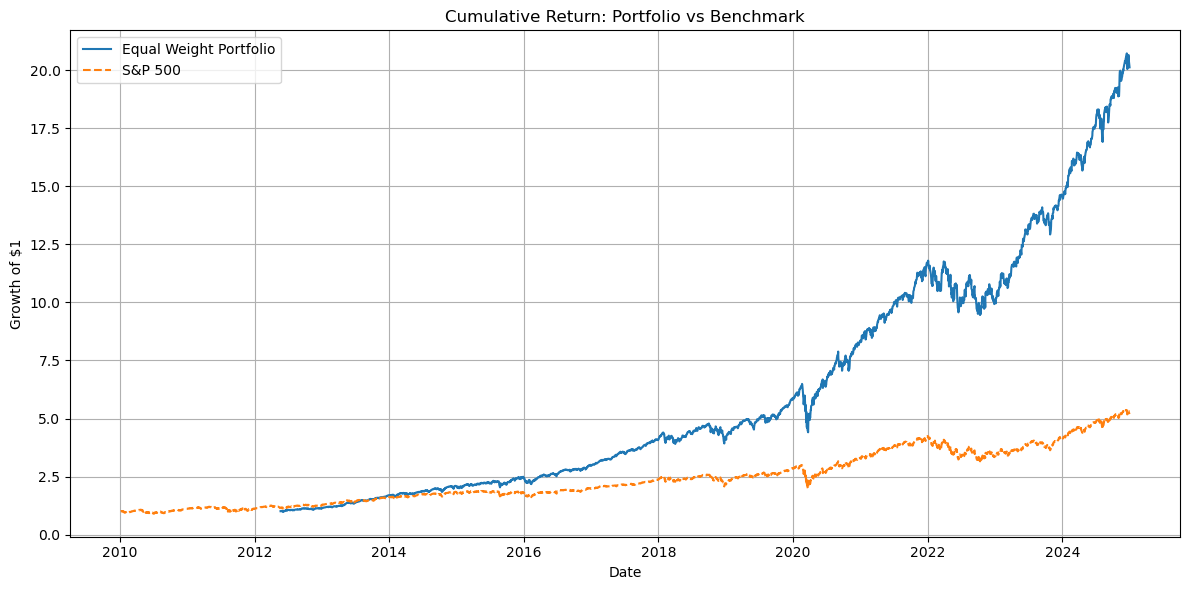

In [62]:
# VISUAL 1: Cumulative Returns vs. S&P 500
benchmark = yf.download("^GSPC", start="2010-01-01", end="2025-01-01", auto_adjust=True)["Close"]
benchmark_cum = (1 + benchmark.pct_change().dropna()).cumprod()

plt.figure(figsize=(12,6))
plt.plot(equal_cum_returns, label="Equal Weight Portfolio")
plt.plot(benchmark_cum, label="S&P 500", linestyle='--')
plt.title("Cumulative Return: Portfolio vs Benchmark")
plt.xlabel("Date"); plt.ylabel("Growth of $1"); plt.grid(); plt.legend(); plt.tight_layout()
plt.show()

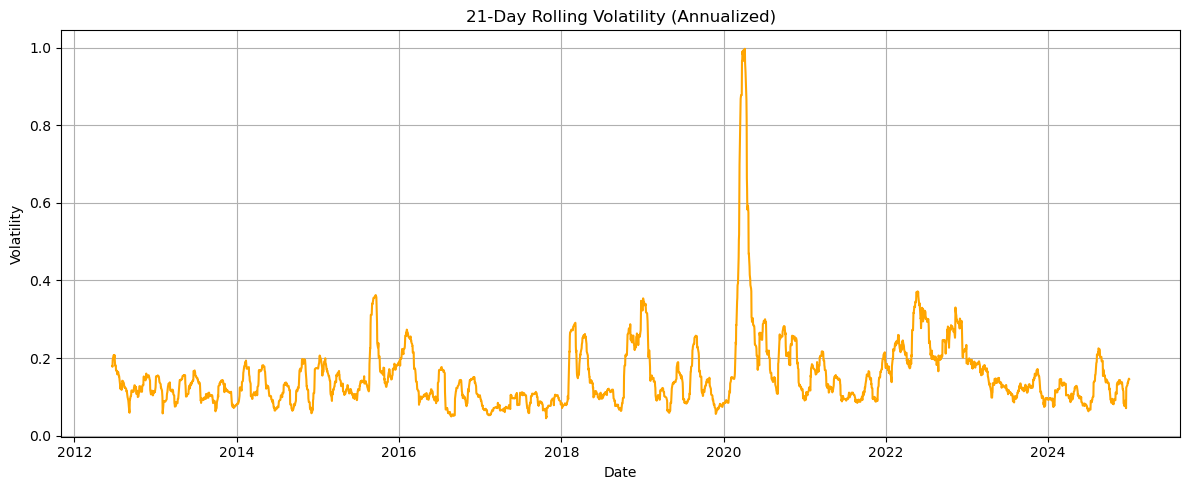

In [64]:
# VISUAL 2: Rolling Volatility
rolling_vol = equal_weight_returns.rolling(21).std() * np.sqrt(252)
plt.figure(figsize=(12,5))
plt.plot(rolling_vol, color='orange')
plt.title("21-Day Rolling Volatility (Annualized)")
plt.ylabel("Volatility"); plt.xlabel("Date"); plt.grid(); plt.tight_layout()
plt.show()

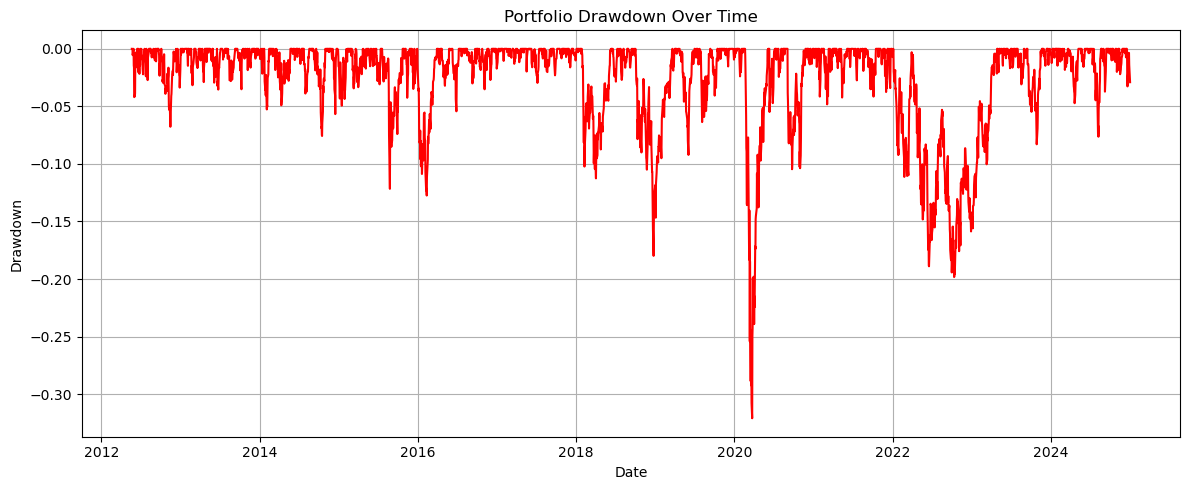

In [66]:
# VISUAL 3: Drawdown Chart
rolling_max = equal_cum_returns.cummax()
drawdown = (equal_cum_returns - rolling_max) / rolling_max
plt.figure(figsize=(12,5))
plt.plot(drawdown, color='red')
plt.title("Portfolio Drawdown Over Time")
plt.ylabel("Drawdown"); plt.xlabel("Date"); plt.grid(); plt.tight_layout()
plt.show()

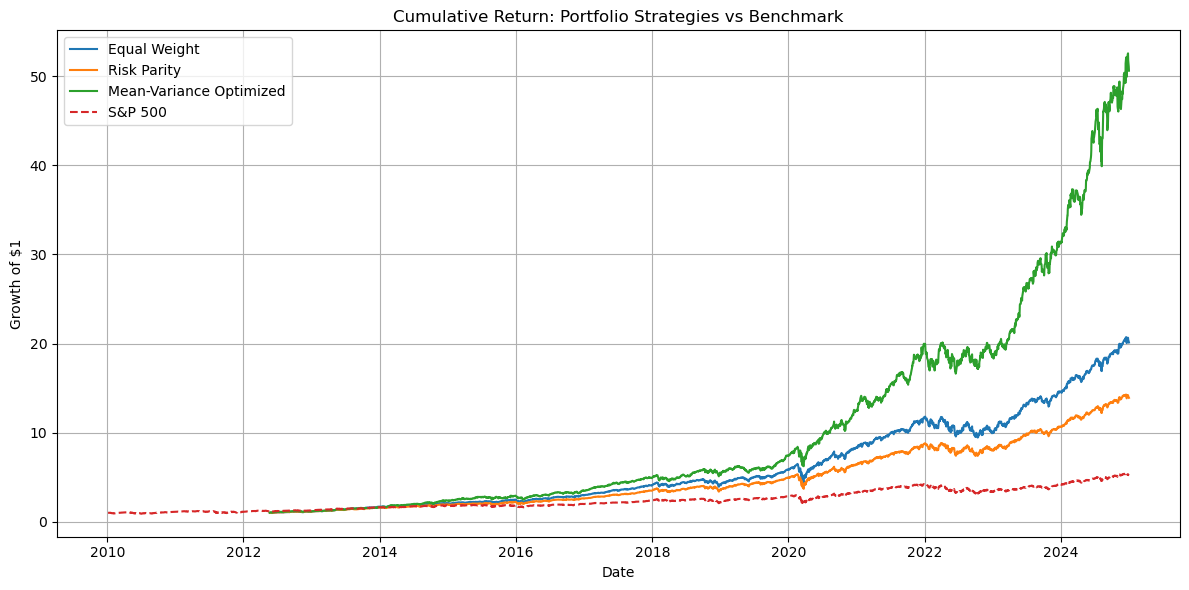

In [68]:
# STEP 9: Compare All Strategies (Equal Weight, Risk Parity, Mean-Variance)

# Construct mean-variance portfolio returns
opt_weight_array = np.array([opt_weights_clean.get(t, 0) for t in price_data.columns])
mean_var_returns = daily_returns.dot(opt_weight_array)
mean_var_cum_returns = (1 + mean_var_returns).cumprod()

# Plot all cumulative returns
plt.figure(figsize=(12,6))
plt.plot(equal_cum_returns, label="Equal Weight")
plt.plot(risk_parity_cum_returns, label="Risk Parity")
plt.plot(mean_var_cum_returns, label="Mean-Variance Optimized")
plt.plot(benchmark_cum, label="S&P 500", linestyle="--")
plt.title("Cumulative Return: Portfolio Strategies vs Benchmark")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.grid(True); plt.legend(); plt.tight_layout()
plt.show()